# IMPORTS

In [173]:
import pandas as pd
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker
from scipy.optimize import differential_evolution
from scipy.optimize import linear_sum_assignment

# DATA COLLECTION CODE

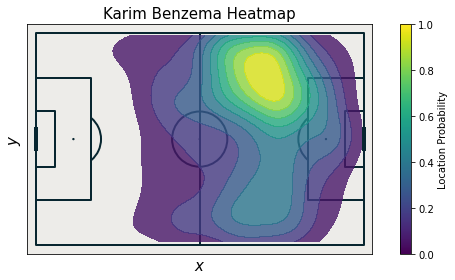

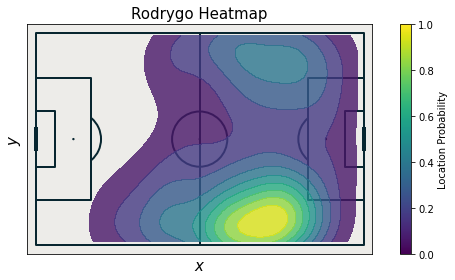

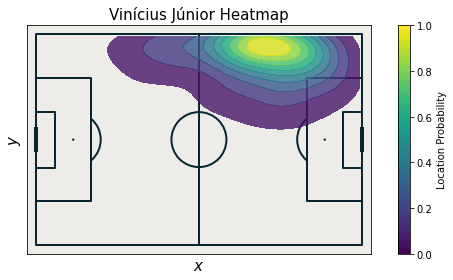

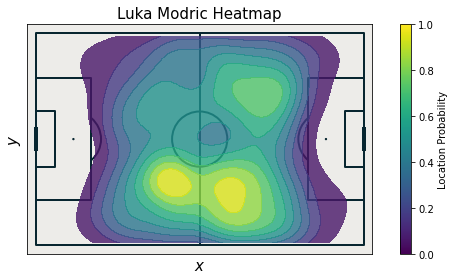

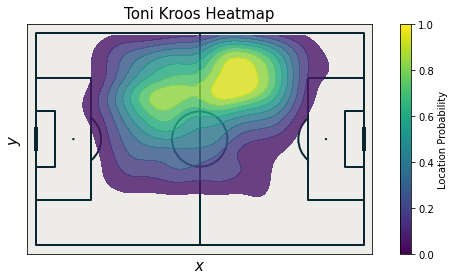

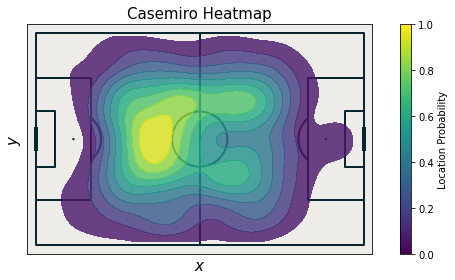

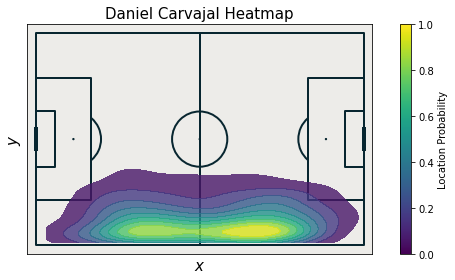

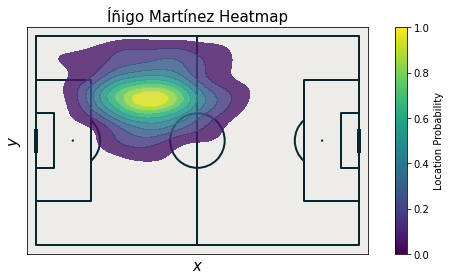

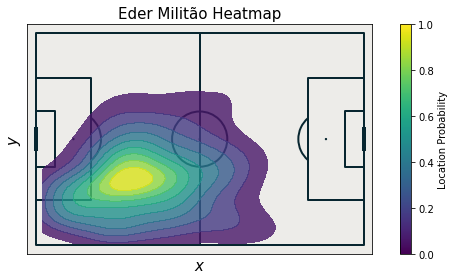

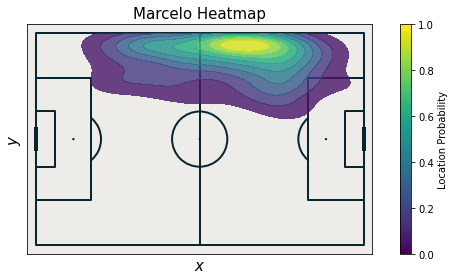

In [239]:
# Read data
data = pd.read_csv("WalkthroughLaLiga.csv")

Real_Madrid = {
    "Karim Benzema": "Forward", "Rodrygo": "Forward", "Vinícius Júnior": "Forward",
    "Luka Modric": "Midfielder", "Toni Kroos": "Midfielder", "Casemiro": "Midfielder",
    "Daniel Carvajal": "Defender", "Íñigo Martínez": "Defender", "Eder Militão": "Defender", "Marcelo": "Defender"
}

pitch = Pitch(pitch_type='opta', pitch_color='#edece9', axis=True, label=False, line_color='#082630', tick=False)

probability_matrix = np.zeros((len(Real_Madrid), 120, 80))

max_prob_positions = []  
for i, player in enumerate(Real_Madrid):

    player_data = data[data['receiver'] == player]
    
    kde = gaussian_kde(np.vstack([player_data.end_x, player_data.end_y]))

    x_grid, y_grid = np.mgrid[
        min(player_data.end_x):max(player_data.end_x):120j,
        min(player_data.end_y):max(player_data.end_y):80j
    ]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    prob = kde(positions).reshape(x_grid.shape)
    prob = prob / np.max(prob)  #normalize
    
    probability_matrix[i] = prob

    # Find the position of maximum probability
    max_prob_idx = np.unravel_index(np.argmax(prob, axis=None), prob.shape)
    max_prob_positions.append([max_prob_idx[0], max_prob_idx[1]])

    # Plot
    fig, ax = pitch.draw(figsize=(8, 4))

    ax.contourf(x_grid, y_grid, prob, cmap='viridis', alpha=.8, locator=ticker.MaxNLocator(prune='lower'))
    
    sm = plt.cm.ScalarMappable(cmap='viridis')
    sm.set_array([])  
    colorbar = plt.colorbar(sm, ax=ax)
    colorbar.set_label('Location Probability')

    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title(f'{player} Heatmap', fontsize=15)
    
    plt.savefig(f"{player}_heatmap.png", dpi=300, bbox_inches='tight')
    
    plt.show()

# OPTIMIZED WITH NO CONSTRAINTS (CONTROL GROUP)

Final optimized positions:alue: 10.09878764533841
[[69.09301335 80.19135867]
 [68.02922766 10.30341296]
 [69.53109991 94.36196596]
 [40.27036708 28.92065549]
 [61.31551234 75.20704854]
 [34.70729223 50.65445254]
 [67.04359527  7.18656749]
 [34.41260303 69.92514744]
 [29.22183609 31.71676451]
 [64.54793599 93.45339529]]
Total number of iterations: 93
Final objective function value: 10.0


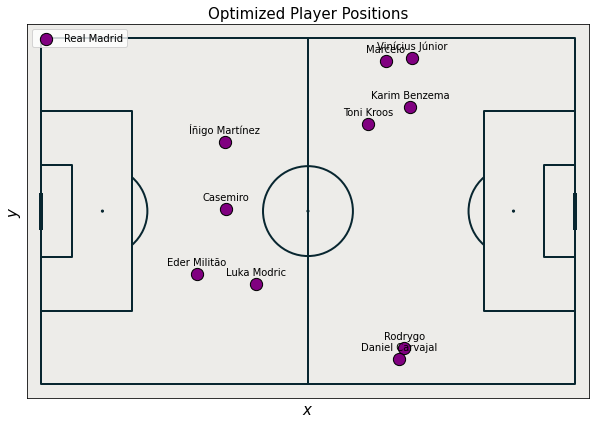

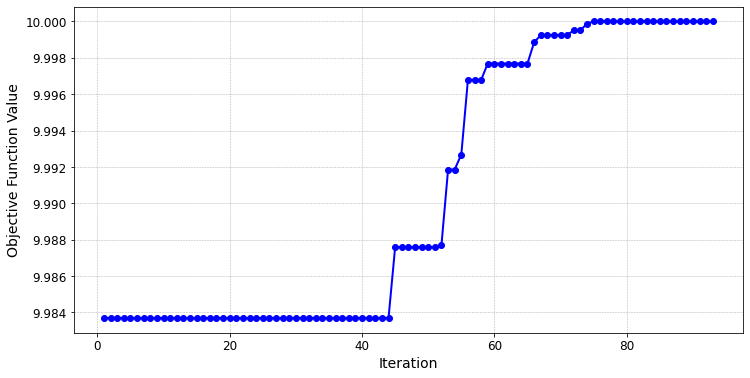

In [169]:
iteration_count = 0
objective_values = []
def iteration_callback(xk, convergence):
    global iteration_count, objective_values
    iteration_count += 1
    # Compute current objective value
    current_objective_value = objective(xk, probability_matrix)
    objective_values.append(-current_objective_value)  
    print(f"Iteration: {iteration_count}, Objective Value: {objective_values[-1]}", end='\r')
    
# Convert max_prob_positions to a flat list for differential_evolution
initial_positions = np.array(max_prob_positions).flatten()

# Objective function to maximize summed probability
def objective(x, probability_matrix):
    n_players = len(Real_Madrid)
    total_probability = 0
    
    for i in range(n_players):
        x_idx = int(np.clip(x[2*i], 0, 119))
        y_idx = int(np.clip(x[2*i+1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
    return -total_probability

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix,), strategy='best1bin',
        popsize=20, tol=1e-4, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=20000, x0=initial_positions
    )
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

final_objective_value = -result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot
fig, ax = pitch.draw(figsize=(10, 6))

for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, 
               edgecolor = 'black', label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, 
            ha='center', va='bottom')

ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

plt.savefig("optimized_positions_unconstrained.png", dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o', color='blue', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Objective Function Value', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot
plt.savefig("objective_function_vs_iteration_unconstrained.png", dpi=300, bbox_inches='tight')
plt.show()

# OPTIMIZED WHILE PREVENTING CLUSTERS

Final optimized positions: Value: 9.846973432910621
[[70.82324431 75.68098608]
 [67.95714087 10.72758369]
 [70.79813044 94.63826841]
 [40.78202805 29.25822064]
 [58.34191339 73.91912988]
 [34.7345672  50.55896484]
 [32.94023208  7.09436933]
 [34.44693665 69.8543538 ]
 [28.41430428 32.39206377]
 [62.52353278 93.15677418]]
Total number of iterations: 1005
Final objective function value: 9.846973440890613


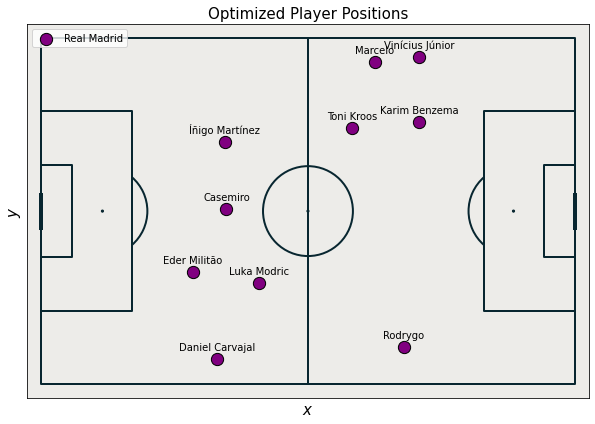

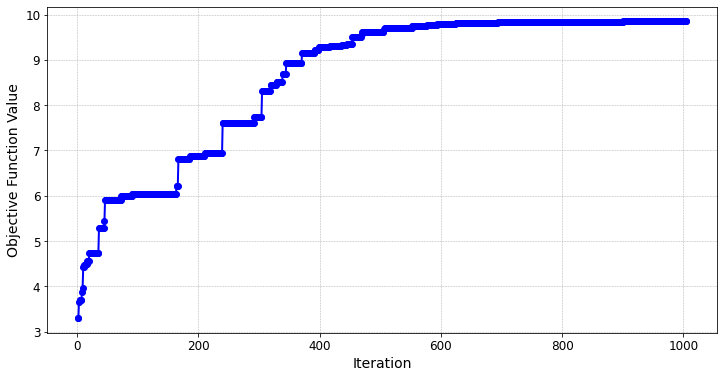

In [171]:
iteration_count = 0
objective_values = []

def iteration_callback(xk, convergence):
    global iteration_count, objective_values
    iteration_count += 1
    current_objective_value = objective(xk, probability_matrix)
    objective_values.append(-current_objective_value)  
    print(f"Iteration: {iteration_count}, Objective Value: {objective_values[-1]}", end='\r')
    
initial_positions = np.array(max_prob_positions).flatten()

# Objective function
def objective(x, probability_matrix):
    n_players = len(Real_Madrid)
    total_probability = 0
    clustering_penalty = 0
    
    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(x[2*i], 0, 119))
        y_idx = int(np.clip(x[2*i+1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 10 units
                clustering_penalty += (10 - distance) ** 2
    
    return -(total_probability - clustering_penalty)

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix,), strategy='best1bin',
        popsize=20, tol=1e-4, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=20000, x0=initial_positions
    )
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

final_objective_value = -result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot
fig, ax = pitch.draw(figsize=(10, 6))

for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, 
               edgecolor = 'black', label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, 
            ha='center', va='bottom')

ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

plt.savefig("optimized_positions_unclustered.png", dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o', color='blue', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Objective Function Value', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("objective_function_vs_iteration_unclustered.png", dpi=300, bbox_inches='tight')
plt.show()

# ADDING OPPOSING TEAM: BALL IN CORNER

Final optimized positions:Value: 99.142682695255733
[[83.33374075 50.01027561]
 [95.82423637 74.99996522]
 [91.63998264 93.72852196]
 [63.03844241 24.93156356]
 [64.17576952 56.23209516]
 [66.65432635 81.24239852]
 [45.78997708 75.22244597]
 [49.99402691 95.87901591]
 [49.99878578 58.35497152]
 [49.99410018 25.01966768]]
Total number of iterations: 436
Final objective function value: 99.14268269525573


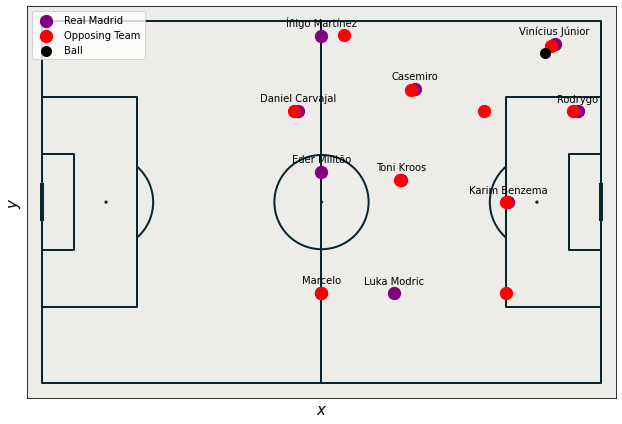

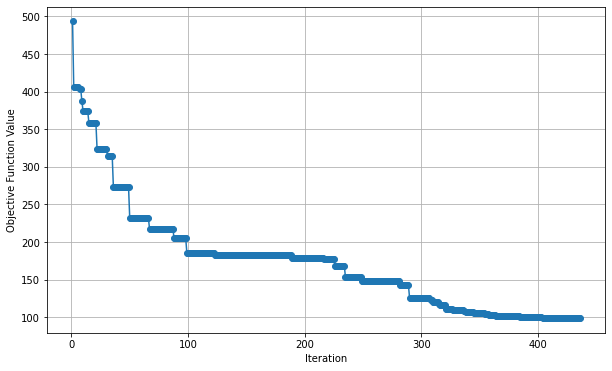

In [175]:
# Define the opposing team positions
opposing_positions = np.array([
    [115, 60], [100, 40],  # Center-backs
    [110, 75], [100, 20],  # Full-backs
    [77, 45], [95, 60], [80, 65],  # Midfielders
    [65, 77], [60, 20],  # Wingers
    [55, 60]  # Striker
])

ball_position = np.array([108, 73])

iteration_count = 0
objective_values = []

initial_positions = np.array(max_prob_positions).flatten()

def iteration_callback(xk, convergence):
    global iteration_count, objective_values
    iteration_count += 1
    current_objective_value = objective(xk, probability_matrix, opposing_positions, ball_position, Real_Madrid)
    objective_values.append(current_objective_value)
    print(f"Iteration: {iteration_count}, Objective Value: {objective_values[-1]}", end='\r')

# Objective function
def objective(x, probability_matrix, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    prob_penalty = 0
    clustering_penalty = 0
    guarding_penalty = 0
    ball_attraction = 0
    assignment_penalty = 0

    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        prob_penalty -= probability_matrix[i, x_idx, y_idx]  
        
        # Apply positional constraints based on player roles
        role = Real_Madrid[list(Real_Madrid.keys())[i]]
        if role == "Defender":
            if positions[i, 0] > 60:
                prob_penalty += 100  
        elif role == "Midfielder":
            if positions[i, 0] < 40 or positions[i, 0] > 80:
                prob_penalty += 50  
        elif role == "Forward":
            if positions[i, 0] < 60:
                prob_penalty += 100 
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  
                clustering_penalty += (15 - distance) ** 2
    
    # Apply guarding penalty
    for i in range(n_players):
        closest_opponent_distance = np.min(np.linalg.norm(positions[i] - opposing_positions, axis=1))
        guarding_penalty += closest_opponent_distance

    # Apply ball attraction penalty
    for i in range(n_players):
        distance_to_ball = np.linalg.norm(positions[i] - ball_position)
        ball_attraction += 1 / (distance_to_ball + 1)  # +1 to avoid division by zero
    
    # Ensure unique guarding assignments using the Hungarian algorithm
    cost_matrix = np.zeros((n_players, len(opposing_positions)))
    for i in range(n_players):
        for j in range(len(opposing_positions)):
            cost_matrix[i, j] = np.linalg.norm(positions[i] - opposing_positions[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment_penalty = cost_matrix[row_ind, col_ind].sum()
    
    return prob_penalty + clustering_penalty + guarding_penalty - ball_attraction + assignment_penalty

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix, opposing_positions, ball_position, Real_Madrid), strategy='best1bin',
        popsize=20, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=1000, x0=initial_positions)
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

final_objective_value = result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot
fig, ax = pitch.draw(figsize=(10, 6))

for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, edgecolors='black', 
               label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, edgecolors='black', 
               label='Opposing Team' if i == 0 else '')

ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)

plt.savefig("optimized_positions.png", dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.savefig("objective_function_vs_iteration.png", dpi=300, bbox_inches='tight')
plt.show()

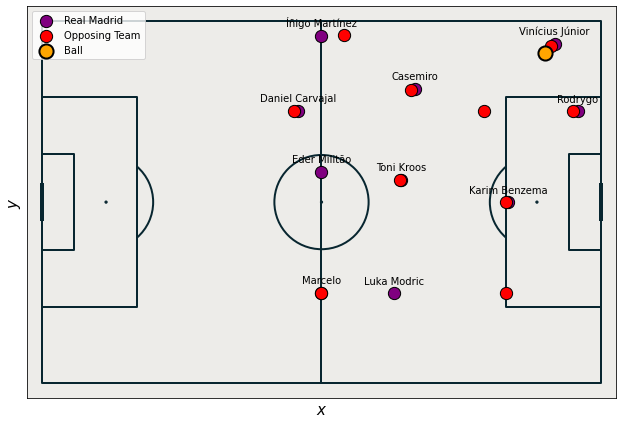

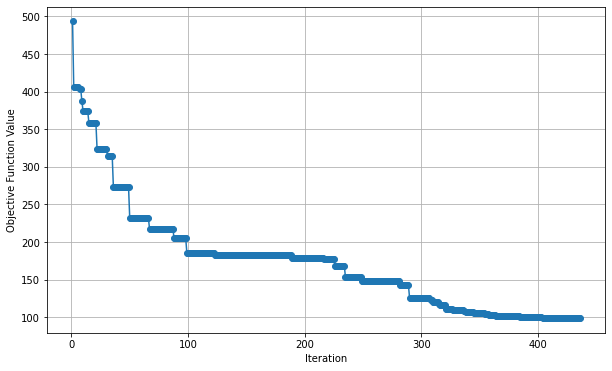

In [178]:
# Plot
fig, ax = pitch.draw(figsize=(10, 6))

for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, edgecolors='black', 
               label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, edgecolors='black', 
               label='Opposing Team' if i == 0 else '')

ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)

plt.savefig("optimized_positions_ballincorner.png", dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.savefig("objective_function_vs_iteration_ballincorner.png", dpi=300, bbox_inches='tight')
plt.show()

# CODE TO FIND OPPONENT POSITIONS

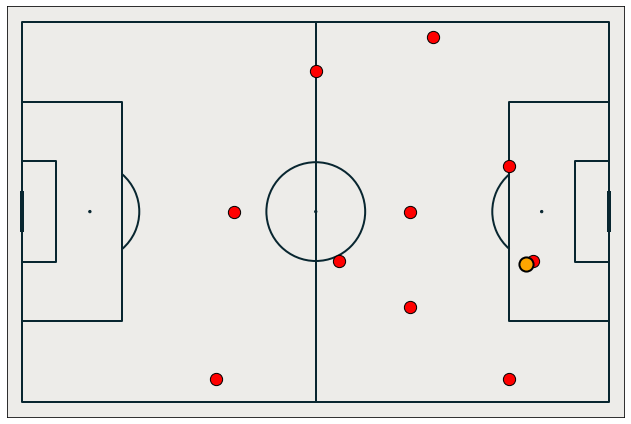

In [235]:
# Plot
fig, ax = pitch.draw(figsize=(10, 6))

# Define the opposing team positions
opposing_positions = np.array([
    [100, 50], [105, 30],  # Center-backs
    [100, 5], [85, 77],  # Full-backs
    [80, 20], [80, 40], [65, 30],  # Midfielders
    [60, 70], [40, 5],  # Wingers
    [44, 40]  # Striker
])

ball_position = np.array([103, 29])

opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, edgecolors='black', 
               label='Opposing Team' if i == 0 else '')

ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

plt.show()

# MIDFIELD

Final optimized positions:Value: 442.45477149634786
[[74.50134781 61.77035581]
 [70.75012032 37.49098106]
 [50.12056942 38.40599693]
 [41.62564007 25.08538634]
 [50.94298291 56.39811897]
 [66.50470026  6.59456375]
 [33.44108455  6.56453886]
 [37.07685751 60.19511581]
 [37.94383193 42.22476762]
 [20.86330506 37.538312  ]]
Total number of iterations: 442
Final objective function value: 442.45477149634786


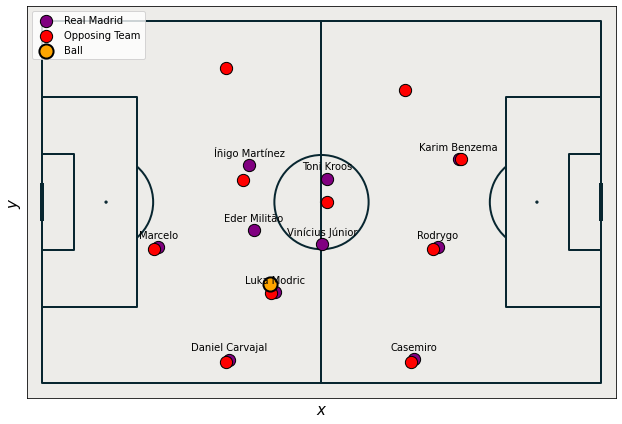

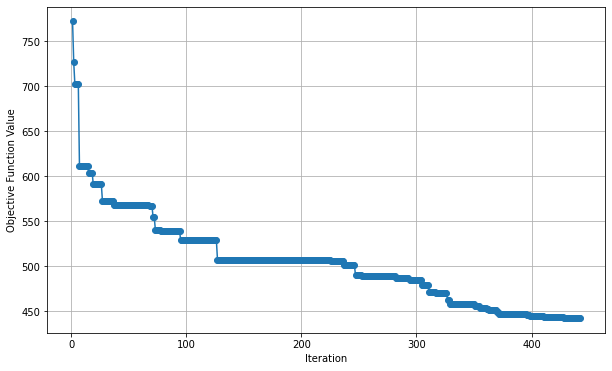

In [221]:
# Define the opposing team positions
opposing_positions = np.array([
    [90, 50], [85, 30],  # Center-backs
    [80, 5], [78, 65],  # Full-backs
    [50, 20], [62, 40], [44, 45],  # Midfielders
    [40, 70], [40, 5],  # Wingers
    [25, 30]  # Striker
])

ball_position = np.array([49, 22])

iteration_count = 0
objective_values = []

initial_positions = np.array(max_prob_positions).flatten()

def iteration_callback(xk, convergence):
    global iteration_count, objective_values
    iteration_count += 1
    current_objective_value = objective(xk, probability_matrix, opposing_positions, ball_position, Real_Madrid)
    objective_values.append(current_objective_value)
    print(f"Iteration: {iteration_count}, Objective Value: {objective_values[-1]}", end='\r')

# Objective function
def objective(x, probability_matrix, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    prob_penalty = 0
    clustering_penalty = 0
    guarding_penalty = 0
    ball_attraction = 0
    assignment_penalty = 0

    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        prob_penalty -= probability_matrix[i, x_idx, y_idx]  
        
        # Apply positional constraints based on player roles
        role = Real_Madrid[list(Real_Madrid.keys())[i]]
        if role == "Defender":
            if positions[i, 0] > 60:
                prob_penalty += 100  
        elif role == "Midfielder":
            if positions[i, 0] < 40 or positions[i, 0] > 80:
                prob_penalty += 50  
        elif role == "Forward":
            if positions[i, 0] < 60:
                prob_penalty += 100  
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 15 units
                clustering_penalty += (15 - distance) ** 2
    
    # Apply guarding penalty
    for i in range(n_players):
        closest_opponent_distance = np.min(np.linalg.norm(positions[i] - opposing_positions, axis=1))
        guarding_penalty += closest_opponent_distance

    # Apply ball attraction penalty
    for i in range(n_players):
        distance_to_ball = np.linalg.norm(positions[i] - ball_position)
        ball_attraction += distance_to_ball**1.1  
    
    # Ensure unique guarding assignments using the Hungarian algorithm
    cost_matrix = np.zeros((n_players, len(opposing_positions)))
    for i in range(n_players):
        for j in range(len(opposing_positions)):
            cost_matrix[i, j] = np.linalg.norm(positions[i] - opposing_positions[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment_penalty = cost_matrix[row_ind, col_ind].sum()

    return prob_penalty + clustering_penalty + guarding_penalty + ball_attraction + assignment_penalty

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix, opposing_positions, ball_position, Real_Madrid), strategy='best1bin',
        popsize=20, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=1000, x0=initial_positions)
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

final_objective_value = result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot
fig, ax = pitch.draw(figsize=(10, 6))

for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, edgecolors='black', 
               label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, edgecolors='black', 
               label='Opposing Team' if i == 0 else '')

ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)

plt.savefig("optimized_positions_midfield.png", dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.savefig("objective_function_vs_iteration_midfield.png", dpi=300, bbox_inches='tight')
plt.show()

# HIGH PRESS

Final optimized positions:Value: 572.5311335531371
[[87.4295902  37.2352117 ]
 [83.39906924  6.82649271]
 [83.41480309 62.18638565]
 [66.64475473 25.00884648]
 [66.6387196  90.57662827]
 [66.65967818 49.934586  ]
 [36.90382027 49.98130152]
 [49.97430388 37.16540894]
 [33.82950654  6.77002329]
 [49.99959518 87.44285323]]
Total number of iterations: 269
Final objective function value: 572.5311335531371


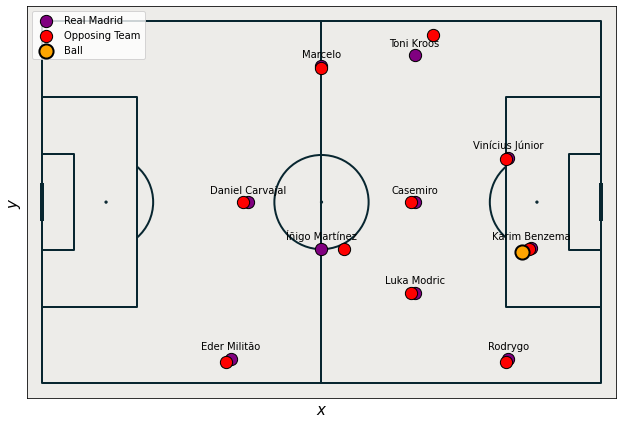

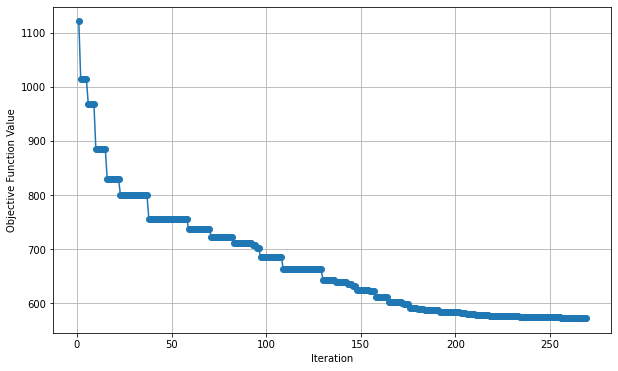

In [238]:
# Define the opposing team positions
opposing_positions = np.array([
    [100, 50], [105, 30],  # Center-backs
    [100, 5], [85, 77],  # Full-backs
    [80, 20], [80, 40], [65, 30],  # Midfielders
    [60, 70], [40, 5],  # Wingers
    [44, 40]  # Striker
])

ball_position = np.array([103, 29])

iteration_count = 0
objective_values = []

initial_positions = np.array(max_prob_positions).flatten()

def iteration_callback(xk, convergence):
    global iteration_count, objective_values
    iteration_count += 1
    current_objective_value = objective(xk, probability_matrix, opposing_positions, ball_position, Real_Madrid)
    objective_values.append(current_objective_value)
    print(f"Iteration: {iteration_count}, Objective Value: {objective_values[-1]}", end='\r')

# Objective function
def objective(x, probability_matrix, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    prob_penalty = 0
    clustering_penalty = 0
    guarding_penalty = 0
    ball_attraction = 0
    assignment_penalty = 0

    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        prob_penalty -= probability_matrix[i, x_idx, y_idx]  
        
        # Apply positional constraints based on player roles
        role = Real_Madrid[list(Real_Madrid.keys())[i]]
        if role == "Defender":
            if positions[i, 0] > 60:
                prob_penalty += 100  
        elif role == "Midfielder":
            if positions[i, 0] < 40 or positions[i, 0] > 80:
                prob_penalty += 50  
        elif role == "Forward":
            if positions[i, 0] < 60:
                prob_penalty += 100  
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 15 units
                clustering_penalty += (15 - distance) ** 2
    
    # Apply guarding penalty
    for i in range(n_players):
        closest_opponent_distance = np.min(np.linalg.norm(positions[i] - opposing_positions, axis=1))
        guarding_penalty += closest_opponent_distance

    # Apply ball attraction penalty
    for i in range(n_players):
        distance_to_ball = np.linalg.norm(positions[i] - ball_position)
        ball_attraction += distance_to_ball**1.1  
    
    # Ensure unique guarding assignments using the Hungarian algorithm
    cost_matrix = np.zeros((n_players, len(opposing_positions)))
    for i in range(n_players):
        for j in range(len(opposing_positions)):
            cost_matrix[i, j] = np.linalg.,.norm(positions[i] - opposing_positions[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment_penalty = cost_matrix[row_ind, col_ind].sum()

    return prob_penalty + clustering_penalty + guarding_penalty + ball_attraction + assignment_penalty

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix, opposing_positions, ball_position, Real_Madrid), strategy='best1bin',
        popsize=20, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=1000, x0=initial_positions)
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

final_objective_value = result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

fig, ax = pitch.draw(figsize=(10, 6))

for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, edgecolors='black', 
               label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, edgecolors='black', 
               label='Opposing Team' if i == 0 else '')

ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)

plt.savefig("optimized_positions_midfield.png", dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.savefig("objective_function_vs_iteration_midfield.png", dpi=300, bbox_inches='tight')
plt.show()